<a href="https://colab.research.google.com/github/brandontan99/Self_Love_App/blob/brandon_ver/Machine_Learning(use_University_Students_only).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [2]:
%cd /content
!git clone https://github.com/brandontan99/Self_Love_App.git
%cd /content/Self_Love_App
!pip install scikit-multilearn

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from skmultilearn.adapt import *
from skmultilearn.problem_transform import *
from skmultilearn.ensemble import * 
from skmultilearn.cluster import *
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import pandas as pd
from data_cleaning import data_cleaning
from Data_Normalization import data_encoding, data_normalization
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import time

# random seed
seed = 0

/content
Cloning into 'Self_Love_App'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 117 (delta 66), reused 23 (delta 11), pack-reused 0
Receiving objects: 100% (117/117), 864.23 KiB | 7.79 MiB/s, done.
Resolving deltas: 100% (66/66), done.
/content/Self_Love_App
     |████████████████████████████████| 92kB 3.9MB/s 


# Data Preparation

In [42]:
def data_normalization(df):
  # explicity min max scale because we already know the range is from 5 to 1
  df.iloc[:,50:64] = df.iloc[:,50:64].apply(lambda x: (x-1)/(5-1)) 
  return df

In [43]:
def filter_university_students_only(df_norm):
  df_norm = df_norm[df_norm["What is your current occupation?_University student"] == 1]
  df_norm = df_norm[[column_name for column_name in df_norm.columns.tolist() if not column_name.startswith("What is your current occupation?")]]
  return df_norm

In [44]:
df = pd.read_csv("WID3006 ML Questionnaire.csv")
df = data_cleaning(df)
df = data_encoding(df)
df_norm = data_normalization(df)
df_norm = filter_university_students_only(df_norm)
df_norm

,Gender: _Male,What boosts your confidence ? _By leading others to success,What boosts your confidence ? _Get the most/ special attention among the members,What boosts your confidence ? _When someone acknowledges you,What boosts your confidence ? _When you accomplish a project,I prefer to spend my money on...._Food,I prefer to spend my money on...._Home Improvements,I prefer to spend my money on...._The latest fashion,I prefer to spend my money on...._The latest technology,How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph,How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud,How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar,How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper,Choose a pet which you prefer to keep._Cat,Choose a pet which you prefer to keep._Dog,Choose a pet which you prefer to keep._Fish,Choose a pet which you prefer to keep._Hamster,Choose a pet which you prefer to keep._Horse,Choose a pet which you prefer to keep._I'm not a pet person,Choose a pet which you prefer to keep._Rabbit,Choose a pet which you prefer to keep._Snake,Choose a pet which you prefer to keep._Tortoise,What is your favorite time of the day?_Evening,What is your favorite time of the day?_Morning,What is your favorite time of the day?_Night,Would you rather visit the future or the past?_The future,Would you rather visit the future or the past?_The past,What do you worry more about the most?_Money,What do you worry more about the most?_The state of the world,What do you worry more about the most?_Your family and friends,What do you worry more about the most?_Your future,"When you retire, you'd like to live..._Exactly where I live now","When you retire, you'd like to live..._In a hectic big city","When you retire, you'd like to live..._In a small town","When you retire, you'd like to live..._Overseas","When you retire, you'd like to live..._Traveling the world",What is your favorite color?_Blue,What is your favorite color?_Green,What is your favorite color?_Purple,What is your favorite color?_Red,...,What is your learning style? (Pick one that benefit you the most)_By doing assignments,What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions,What is your learning style? (Pick one that benefit you the most)_By reading a physical book,What is your learning style? (Pick one that benefit you the most)_By reading an e-Book,Do you enjoy socializing with large groups of people?,Do you enjoy challenges?,How creative of a person do you think you are?,How logical of a person do you think you are?,Would you prefer to engage your brain more than your body?,Are you a curious person?,Are you a perfectionist?,Are you a trusting person?,Do you have lot of patience?,Do you organize your schedule well?,Do you like to sit in front of a computer for long hours?,Do you enjoy making others happy?,Can you understand others' perspectives and feelings?,How confident are you in your own abilities?,Badminton,Playing computer games,Playing board games,Reading,Team sports,Exercising,Writing,Dancing,Gardening,Painting,Cooking,Singing,Puzzles,Collecting,Fishing,Watching movies,Watching TV series,Sleeping,Photography and Videography,Listening to music,Crocheting,Playing a musical instrument
0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0.25,0.50,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,1.00,0.75,0.50,0.50,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0.75,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.75,0.75,1.00,0.75,1.00,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0

In [20]:
for i, name in enumerate(df_norm.columns):
  print(i, name)

0 Gender: _Male
1 What boosts your confidence ? _By leading others to success
2 What boosts your confidence ? _Get the most/ special attention among the members
3 What boosts your confidence ? _When someone acknowledges you
4 What boosts your confidence ? _When you accomplish a project
5 I prefer to spend my money on...._Food
6 I prefer to spend my money on...._Home Improvements
7 I prefer to spend my money on...._The latest fashion
8 I prefer to spend my money on...._The latest technology
9 How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph
10 How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud
11 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar
12 How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper
13 Choose a pet which you prefer to keep._Cat
14 Choose a pet which you prefer to keep._Dog
15 Choose

In [50]:
def filter_features(best_k_features, df_norm):
  return df_norm[ [column_name 
                    for column_name in df_norm.columns 
                    for question in best_k_features 
                    if column_name.startswith(question)]]

x = filter_features(best_k_features, df_norm)
x

,Gender: _Male,What boosts your confidence ? _By leading others to success,What boosts your confidence ? _Get the most/ special attention among the members,What boosts your confidence ? _When someone acknowledges you,What boosts your confidence ? _When you accomplish a project,I prefer to spend my money on...._Food,I prefer to spend my money on...._Home Improvements,I prefer to spend my money on...._The latest fashion,I prefer to spend my money on...._The latest technology,How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph,How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud,How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar,How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper,What is your favorite time of the day?_Evening,What is your favorite time of the day?_Morning,What is your favorite time of the day?_Night,Would you rather visit the future or the past?_The future,Would you rather visit the future or the past?_The past,What do you worry more about the most?_Money,What do you worry more about the most?_The state of the world,What do you worry more about the most?_Your family and friends,What do you worry more about the most?_Your future,"When you retire, you'd like to live..._Exactly where I live now","When you retire, you'd like to live..._In a hectic big city","When you retire, you'd like to live..._In a small town","When you retire, you'd like to live..._Overseas","When you retire, you'd like to live..._Traveling the world",What is your favorite color?_Blue,What is your favorite color?_Green,What is your favorite color?_Purple,What is your favorite color?_Red,What is your favorite color?_White,What is your favorite color?_Yellow,What is your learning style? (Pick one that benefit you the most)_By attending online courses,What is your learning style? (Pick one that benefit you the most)_By doing assignments,What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions,What is your learning style? (Pick one that benefit you the most)_By reading a physical book,What is your learning style? (Pick one that benefit you the most)_By reading an e-Book,Do you enjoy socializing with large groups of people?,Do you enjoy challenges?,How creative of a person do you think you are?,How logical of a person do you think you are?,Are you a curious person?,Are you a perfectionist?,Are you a trusting person?,Do you have lot of patience?,Do you organize your schedule well?,Do you like to sit in front of a computer for long hours?,Do you enjoy making others happy?,Can you understand others' perspectives and feelings?,How confident are you in your own abilities?
0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0.25,0.50,0.75,0.75,0.75,0.75,0.75,0.75,0.75,1.00,0.75,0.50,0.50
1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.75,0.75,0.75,0.75,1.00,1.00,0.50,0.75,0.75,0.75,1.00,0.75,1.00
2,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0.25,0.75,0.75,1.00,1.00,1.00,1.00,0.50,1.00,1.00,1.00,1.00,0.75
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0.75,0.75,0.50,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
4,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.00,0.25,1.00,0.75,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.75,0.75,0.50,0.75,0.75,0.75,0.75,0.50,1.00,0.25,0.75,0.75,0.75
187,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0.00,1.00,0.50,0.75,1.00,0.25,0.75,0.

In [45]:
x = df_norm.iloc[:, :61]
y = df_norm.iloc[:, 61:]

In [51]:
x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
print("Number of train dataset:", len(x_train))
print("Number of test dataset:", len(x_test))

Number of train dataset: 133
Number of test dataset: 34


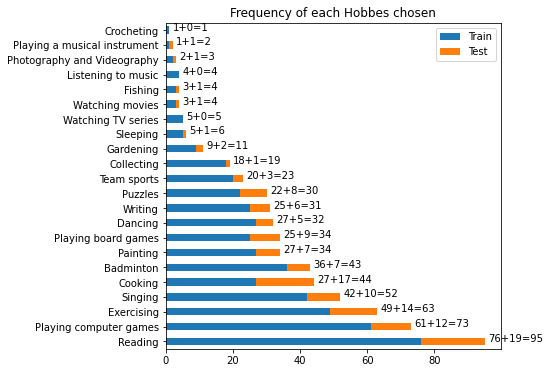

In [25]:
# draw the distribution of the hobbies with a horizontal bar chart
distribution_of_hobbies = y.sum().sort_values(ascending=False)
distribution_of_hobbies_train_test = pd.DataFrame(np.concatenate([y_train.sum(axis=0)[:,None], y_test.sum(axis=0)[:,None]], axis=1), index=y.columns, columns=["Train","Test"])
distribution_of_hobbies_train_test = distribution_of_hobbies_train_test.reindex(distribution_of_hobbies.index)
distribution_of_hobbies_train_test.plot(kind='barh', figsize=(6, 6), title="Frequency of each Hobbes chosen", stacked=True)

# put the frequency text on the right of the bar chart
for i, (row_index, row) in enumerate(distribution_of_hobbies_train_test.iterrows()):
  train_value = row["Train"]
  test_value = row["Test"]
  sum_value = train_value + test_value
  plt.text(x=sum_value+1 , y =i , s=f"{int(train_value)}+{int(test_value)}={int(sum_value)}" , fontdict=dict(fontsize=10))

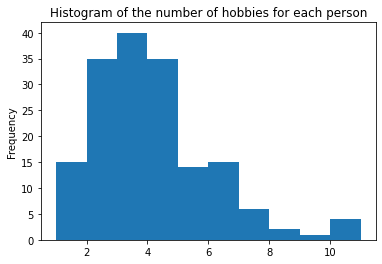

In [26]:
y.sum(axis=1).plot.hist(title='Histogram of the number of hobbies for each person')

# Models

In [27]:
# Base Classifiers ( dict format --> (name, func) : params )
base_models = {
    ("Decision_Tree", DecisionTreeClassifier) : {'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'min_weight_fraction_leaf':[0.0,0.5],'random_state':[seed]},
    ("Extra_Tree", ExtraTreeClassifier) : {'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'min_weight_fraction_leaf':[0.0,0.5],'random_state':[seed]},
    ("Extra_Trees", ExtraTreesClassifier) : {'n_estimators':range(90,120,10),'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'n_jobs':[-1],'random_state':[seed]},
    ("Random_Forest", RandomForestClassifier) :{'n_estimators':range(90,120,10),'min_samples_split':range(2,5),'min_samples_leaf':range(1,4),'n_jobs':[-1],'random_state':[seed]},
    ("MLP", MLPClassifier) : {'hidden_layer_sizes': [(128,64,32),(64,32),(64)],'alpha':[1e-3, 1e-2, 1e-1], 'max_iter': [2000],'random_state':[seed]},
    ("Ridge", RidgeClassifierCV) : {'fit_intercept':[True]}
}

base_models_with_errors = {
    # Error: No neighbors found for test samples array (need to increase the radius size to 20, only can run)
    ("Radius_Neighbours", RadiusNeighborsClassifier) : {'radius':[1.0,1.5,2.0],'leaf_size':range(20,40),'p':range(1,3)},
}

# Adaptation approaches
adapt_models = {
    ("Binary_Relevance_kNN_A", BRkNNaClassifier) : {'k': range(1,3)},
    ("Binary_Relevance_kNN_B", BRkNNbClassifier) : {'k': range(1,3)},
    ("Multi-Label_KNN", MLkNN) : {'k': range(1,3), 's': [0.5, 0.7, 1.0]},
    ("ARAM_Neural_Network", MLARAM) : {'threshold':[0.05], 'vigilance':[0.95]},
    ("Twin_SVM", MLTSVM) : {'c_k': [2**i for i in range(-5, 5, 2)]} # need sparse input
}

# Problem Transformation
problem_transform = {
    "Binary_Relevance" : BinaryRelevance,
    "Classifier_Chain" : ClassifierChain,
    # "Label_Powerset" : LabelPowerset # too many output because 2^20 = 1048576
}

# Ensembles of Classifiers
emsemble_methods = {
    "Distinct_Random k-labtest" : RakelD,
    "Overlapping_Random_k-labtest" : RakelO,
    "Label_Space_Partitoning" : LabelSpacePartitioningClassifier,
    "Majoity_Voting" : MajorityVotingClassifier
}
# Multi-label embeddings (KIV)

# Hyperparameters

In [28]:
# Hyperparameters Tuning
num_of_kfold_splits = 5

# Training

### Adaptation approaches

In [53]:
results = {}
scoring = 'f1_micro'
y_sparse = sparse.csr_matrix(y_train)
x_sparse = sparse.csr_matrix(x_train)
for (model_name, model), params in adapt_models.items():
  kfold = KFold(n_splits=num_of_kfold_splits, random_state=None)
  clf = GridSearchCV(model(), params, cv=kfold, n_jobs=-1, scoring=scoring) # n_jobs=-1, << this cause error for some reason...
  if model_name == "Twin_SVM": # this model need sparse input
    clf.fit(x_sparse, y_sparse)
  else:
    clf.fit(x_train, y_train)
  results[model_name] = clf
  print(model_name,clf.best_score_)

Binary_Relevance_kNN_A 0.34404534550570026
Binary_Relevance_kNN_B 0.02741942275286118
Multi-Label_KNN 0.34404534550570026
ARAM_Neural_Network 0.323932773888538
Twin_SVM 0.39522654202315105


### Problem Transformation

In [54]:
scoring = 'f1_micro'
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
# Random forest and ExtraTrees takes about 20 minutes each, if dw to wait, can just comment out these 2 algo in the dict above
for strategy_name, strategy in problem_transform.items():
  for (model_name, model), params in base_models.items():
    parameters = {}
    for param_name, param_value in params.items():
      parameters["classifier__"+param_name] = param_value
    kfold = KFold(n_splits=num_of_kfold_splits, random_state=None) 
    clf = GridSearchCV(strategy(classifier=model()), parameters, cv=kfold, n_jobs=-1, scoring=scoring) # n_jobs=-1, << this cause error for some reason...
    clf.fit(x_train, y_train)
    results[f"{strategy_name}_{model_name}"] = clf
    print(f"{strategy_name}_{model_name}",clf.best_score_)

Binary_Relevance_Decision_Tree 0.33445105072890013
Binary_Relevance_Extra_Tree 0.3445093927411842
Binary_Relevance_Extra_Trees 0.34327410171024875
Binary_Relevance_Random_Forest 0.317701162891746
Binary_Relevance_MLP 0.37013506101741395
Binary_Relevance_Ridge 0.3263876390180192
Classifier_Chain_Decision_Tree 0.3580949751452839
Classifier_Chain_Extra_Tree 0.3486286955651269
Classifier_Chain_Extra_Trees 0.33413653419401884
Classifier_Chain_Random_Forest 0.3087458011086742
Classifier_Chain_MLP 0.3569924144924145
Classifier_Chain_Ridge 0.29455002222531285


### Ensembles of Classifiers (Under reconstruction)

#### Adaptation approaches

In [ ]:
def convertToParamsForProblemTransformation(base_models):
  parameters = []
  for (model_name, model), params in base_models.items():
    parameter = {}
    parameter["classifier"] = model()
    for param_name, param_value in params.items():
      paramter["classifier__"+param_name] = param_value
    parameters.append(parameter)

  return paramters

In [ ]:
scoring = 'f1_micro'
for emsemble_name, emsemble_method in emsemble_methods.items():
  for strategy_name, strategy in problem_transform.items():
    for base_model_name, base_model in base_models.items():
      kfold = KFold(n_splits=num_of_kfold_splits, random_state=seed)
      model = strategy(
              classifier = base_model(),
              require_dense = [False, True] # depens on the data is sparse or dense
      )
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1, scoring=scoring)
      results.append(cv_results)
      names.append(model_name)
      msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
      print(msg)
      classifier = MajorityVotingClassifier(
    clusterer = FixedLabelSpaceClusterer(clusters = [[1,3,4], [0, 2, 5]]),
    classifier = ClassifierChain(classifier=GaussianNB())
)
classifier.fit(X_train,y_train)
predictions = classifier.predict(X_test)

In [ ]:
classifier = MajorityVotingClassifier(
    clusterer = FixedLabelSpaceClusterer(clusters = [[1,3,4], [0, 2, 5]]),
    classifier = ClassifierChain(classifier=GaussianNB())
)
classifier.fit(X_train,y_train)


# Evaluation 

In [31]:
def display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro"):
  result_table = []
  for model_name, model in results.items():
    y_pred = model.predict(x_test)
    score = f1_score(y_test, y_pred, average=f1_average)
    score_by_class = f1_score(y_test, y_pred, average=None, zero_division=0)
    result_table.append([score]+score_by_class.tolist())

  # f1 score evaluation result overall and by class in percentage 
  # 0 means no True Positive at all or there is no example of that class in the y_text at all
  result_table_df = pd.DataFrame(result_table, columns=["Overall"]+y.columns.tolist(), index=results.keys()) * 100
  result_table_df.sort_values(by='Overall', inplace=True, ascending=False)

  # arrange the columns according to the frequency of each hobbies in the test set
  sorted_columns = distribution_of_hobbies_train_test["Test"].sort_values(ascending=False).index.tolist()
  modified_column_names = [column + "(" + str(int(distribution_of_hobbies_train_test.loc[column,"Test"]))+")" for column in sorted_columns]
  result_table_df = result_table_df[["Overall"] + sorted_columns] # sort the columns by the frequency of each hobbies in the test set 
  result_table_df.columns = [["Overall"] + modified_column_names] # add the frequency of each hobbies in the test set in the column name
  return result_table_df

display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Reading(19),Cooking(17),Exercising(14),Playing computer games(12),Singing(10),Playing board games(9),Puzzles(8),Painting(7),Badminton(7),Writing(6),Dancing(5),Team sports(3),Gardening(2),Sleeping(1),Collecting(1),Playing a musical instrument(1),Watching movies(1),Fishing(1),Photography and Videography(1),Watching TV series(0),Listening to music(0),Crocheting(0)
Twin_SVM,41.624365,63.636364,61.538462,70.588235,50.000000,34.482759,35.714286,48.000000,38.709677,14.814815,29.629630,22.222222,46.153846,0.000000,0.0,0.0,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0
Classifier_Chain_Decision_Tree,40.310078,59.459459,50.000000,25.000000,46.153846,54.545455,11.111111,50.000000,25.000000,37.500000,20.000000,42.857143,100.000000,0.000000,0.0,20.0,0.000000,0.0,50.000000,0.0,0.0,0.0,0.0
Binary_Relevance_Extra_Tree,37.209302,59.459459,33.333333,33.333333,42.857143,23.076923,50.000000,26.666667,44.444444,40.000000,33.333333,22.222222,33.333333,40.000000,0.0,0.0,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0
Multi-Label_KNN,37.096774,72.000000,0.000000,11.764706,51.428571,34.482759,40.000000,0.000000,0.000000,36.363636,0.000000,0.000000,80.000000,28.571429,0.0,0.0,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0
Binary_Relevance_MLP,36.909871,66.666667,28.571429,50.000000,25.000000,27.272727,18.181818,20.000000,42.857143,11.764706,14.285714,40.000000,85.714286,0.000000,0.0,0.0,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0
ARAM_Neural_Network,36.567164,73.170732,44.444444,41.379310,32.000000,28.571429,42.105263,35.294118,12.500000,31.578947,0.000000,16.666667,40.000000,0.000000,0.0,0.0,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0
Binary_Relevance_kNN_A,36.293436,70.000000,40.000000,35.714286,35.714286,31.578947,40.000000,22.222222,13.333333,35.294118,15.384615,16.666667,44.444444,0.000000,0.0,0.0,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0
Classifier_Chain_MLP,35.555556,60.465116,34.782609,50.000000,34.782609,27.272727,16.666667,20.000000,30.769231,11.764706,16.666667,22.222222,66.666667,0.000000,0.0,0.0,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0
Classifier_Chain_Extra_Tree,35.471698,61.111111,37.500000,51.851852,30.769231,45.454545,21.052632,30.769231,11.111111,40.000000,26.666667,22.222222,33.333333,0.000000,0.0,0.0,0.000000,0.0,66.666667,0.0,0.0,0.0,0.0
Binary_Relevance_Decision_Tree,33.333333,50.000000,53.333333,27.272727,37.037037,25.000000,11.111111,16.666667,28.571429,26.666667,18.181818,44.444444,85.714286,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


# Outlier Removal
https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/

# Feature Selection

### Chi Square Analysis
https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [34]:
def sort_by_questions(data, x, ascending = False):
  question_answers_score = pd.DataFrame(data, index=x.columns).reset_index()
  question_answers_score["Question"] = question_answers_score["index"].apply(lambda column_name : column_name.split("_")[0])
  question_score = question_answers_score.groupby("Question").mean().sort_values(0, ascending=ascending)
  return question_score

def select_best_k_features(df, k=None, thres_value=None, more_than_thres_value = True ):
  if k:
    # choose the k best feature by explicitly stating the length
    best_k_features = df.index[:k].tolist()
  elif thres_value:
    # choose the k best feature by certain threshold
    if more_than_thres_value:
      best_k_features = df[df[0] > thres_value].index.tolist()
    else:
      best_k_features = df[df[0] < thres_value].index.tolist()
  
  return best_k_features

def label_encoding(data_source):
  df = pd.read_csv(data_source)
  df = df.iloc[2:,:].reset_index(drop=True) # delete first 2 responses
  df1 = df.iloc[:, 1:3]
  df2 = df.iloc[:, 18:]
  df_ranges = df.iloc[:, 4:18]
  df_categories = pd.concat([df1, df2], axis =1)
  df_categories_encoder = df_categories.apply(LabelEncoder().fit_transform)
  return pd.concat([df_categories_encoder, df_ranges], axis =1)

label_encoding_df = label_encoding("WID3006 ML Questionnaire.csv")

selected_features = [] 
label_encoding_df = label_encoding_df[label_encoding_df["What is your current occupation?"] == 3] # 3 is student
label_encoding_df = label_encoding_df[[column_name for column_name in label_encoding_df.columns.tolist() if not column_name.startswith("What is your current occupation?")]]  
x_train_label_encoded, _, y_train, _ = train_test_split(label_encoding_df.to_numpy(), y_numpy, test_size=0.2, random_state=seed)
for i in range(y_numpy.shape[1]):
    selector = SelectKBest(chi2, k='all')
    selector.fit(x_train_label_encoded, y_train[:,i])
    selected_features.append(list(selector.scores_))

# MeanCS 
selected_features = np.mean(selected_features, axis=0) 


# // MaxCS
# selected_features = np.max(selected_features, axis=0) 
# print(selected_features)
chi2_analysis = pd.DataFrame(selected_features[:,None], index=label_encoding_df.columns).sort_values(0, ascending = False)
chi2_analysis


,0
Choose a pet which you prefer to keep.,2.661988
Gender:,2.526642
How do you organize your thoughts? Please pick whichever is closest.,1.818323
What is your favorite color?,1.804169
"When you retire, you'd like to live...",1.097243
I prefer to spend my money on....,0.983913
What is your learning style? (Pick one that benefit you the most),0.739105
Do you enjoy socializing with large groups of people?,0.691179
Do you like to sit in front of a computer for long hours?,0.615506
Would you rather visit the future or the past?,0.572487


##### Evaluation

In [35]:
# Twin SVM best number of features is 13 with 36.8 f1 score
# params = adapt_models[("Twin_SVM", MLTSVM)]
params = base_models[("Extra_Tree", ExtraTreeClassifier)]
params = {"classifier__"+param_name:param for param_name, param in params.items()}
params["classifier"] = [ExtraTreeClassifier()]
scoring = 'f1_micro'

results = {}
for i in range(len(chi2_analysis.index)):
  best_k_features = select_best_k_features(chi2_analysis, k=i+1)
  x = filter_features(best_k_features, df_norm)
  x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
  # y_sparse = sparse.csr_matrix(y_train)
  # x_sparse = sparse.csr_matrix(x_train)
  # clf = GridSearchCV(MLTSVM(), params, cv=5, n_jobs=-1, scoring=scoring)
  # clf.fit(x_sparse, y_sparse)
  clf = GridSearchCV(ClassifierChain(), params, cv=5, n_jobs=-1, scoring=scoring)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  score = f1_score(y_test, y_pred, average="micro")
  print("Number of best k features:", len(best_k_features), "score:",score)

Number of best k features: 1 score: 0.27586206896551724
Number of best k features: 2 score: 0.25
Number of best k features: 3 score: 0.33170731707317075
Number of best k features: 4 score: 0.34108527131782945
Number of best k features: 5 score: 0.4056939501779359
Number of best k features: 6 score: 0.40433212996389895
Number of best k features: 7 score: 0.3269961977186312
Number of best k features: 8 score: 0.25974025974025977
Number of best k features: 9 score: 0.36153846153846153
Number of best k features: 10 score: 0.3939393939393939
Number of best k features: 11 score: 0.36286919831223624
Number of best k features: 12 score: 0.4360902255639098
Number of best k features: 13 score: 0.34024896265560167
Number of best k features: 14 score: 0.37121212121212127
Number of best k features: 15 score: 0.33198380566801616
Number of best k features: 16 score: 0.34657039711191334
Number of best k features: 17 score: 0.3543307086614173
Number of best k features: 18 score: 0.3240740740740741
Numb

- Initially, **Twin SVM** is used to test the model by adding the top feature at each iteration to determine the best number of features.
- However, the best number of features obtained was 12. Then, these 12 features were used to train other algorithms. In the end, **Classifier_Chain_Extra_Tree** beat all the other algorithms.
- After that, **Classifier_Chain_Extra_Tree** was used to test the model by adding the top feature at each iteration in hope of finding a better number of features.
- As a result, **Classifier_Chain_Extra_Tree** tops at 12 features as well.

In [36]:
best_k_features = select_best_k_features(chi2_analysis, k=12)
best_k_features

['Choose a pet which you prefer to keep.',
 'Gender: ',
 'How do you organize your thoughts? Please pick whichever is closest.',
 'What is your favorite color?',
 "When you retire, you'd like to live...",
 'I prefer to spend my money on....',
 'What is your learning style? (Pick one that benefit you the most)',
 'Do you enjoy socializing with large groups of people?',
 'Do you like to sit in front of a computer for long hours?',
 'Would you rather visit the future or the past?',
 'Do you have lot of patience?',
 'What boosts your confidence ? ']

In [41]:
# 12 features
display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Reading(19),Cooking(17),Exercising(14),Playing computer games(12),Singing(10),Playing board games(9),Puzzles(8),Painting(7),Badminton(7),Writing(6),Dancing(5),Team sports(3),Gardening(2),Sleeping(1),Collecting(1),Playing a musical instrument(1),Watching movies(1),Fishing(1),Photography and Videography(1),Watching TV series(0),Listening to music(0),Crocheting(0)
Classifier_Chain_Extra_Tree,43.609023,63.414634,34.482759,56.000000,40.000000,59.259259,33.333333,42.105263,42.857143,52.631579,0.000000,36.363636,66.666667,0.000000,0.000000,0.0,0.000000,0.0,100.0,0.0,0.0,0.0,0.0
Binary_Relevance_Extra_Tree,42.914980,54.545455,57.142857,51.851852,44.444444,37.500000,33.333333,18.181818,50.000000,52.631579,0.000000,28.571429,44.444444,33.333333,0.000000,0.0,0.000000,0.0,100.0,0.0,0.0,0.0,0.0
Twin_SVM,38.554217,69.387755,57.777778,63.414634,50.000000,47.058824,41.176471,41.176471,32.258065,23.529412,26.666667,22.222222,31.578947,0.000000,0.000000,0.0,0.000000,0.0,100.0,0.0,0.0,0.0,0.0
ARAM_Neural_Network,37.735849,71.428571,38.461538,51.851852,25.000000,45.454545,28.571429,14.285714,22.222222,25.000000,12.500000,33.333333,75.000000,0.000000,0.000000,0.0,0.000000,0.0,100.0,0.0,0.0,0.0,0.0
Binary_Relevance_MLP,37.500000,66.666667,27.272727,47.619048,45.454545,21.052632,33.333333,14.285714,26.666667,15.384615,15.384615,54.545455,57.142857,0.000000,0.000000,0.0,0.000000,0.0,100.0,0.0,0.0,0.0,0.0
Binary_Relevance_kNN_A,36.226415,70.000000,46.666667,44.444444,24.000000,38.095238,16.666667,13.333333,22.222222,22.222222,13.333333,37.500000,85.714286,0.000000,0.000000,0.0,0.000000,0.0,100.0,0.0,0.0,0.0,0.0
Multi-Label_KNN,36.226415,70.000000,46.666667,44.444444,24.000000,38.095238,16.666667,13.333333,22.222222,22.222222,13.333333,37.500000,85.714286,0.000000,0.000000,0.0,0.000000,0.0,100.0,0.0,0.0,0.0,0.0
Classifier_Chain_MLP,34.951456,65.000000,17.391304,57.142857,33.333333,27.272727,36.363636,20.000000,0.000000,16.666667,0.000000,28.571429,50.000000,0.000000,0.000000,0.0,0.000000,0.0,100.0,0.0,0.0,0.0,0.0
Classifier_Chain_Extra_Trees,34.594595,61.904762,30.000000,42.105263,28.571429,35.294118,20.000000,0.000000,22.222222,18.181818,0.000000,0.000000,80.000000,0.000000,0.000000,0.0,0.000000,0.0,100.0,0.0,0.0,0.0,0.0
Binary_Relevance_Extra_Trees,33.846154,63.636364,28.571429,42.105263,25.000000,33.333333,20.000000,0.000000,22.222222,18.181818,0.000000,0.000000,66.666667,0.000000,0.000000,0.0,0.000000,0.0,100.0,0.0,0.0,0.0,0.0


### Recursive Feature Elimination (rfe)
https://machinelearningmastery.com/rfe-feature-selection-in-python/

Badminton 1
48 Do you enjoy socializing with large groups of people?


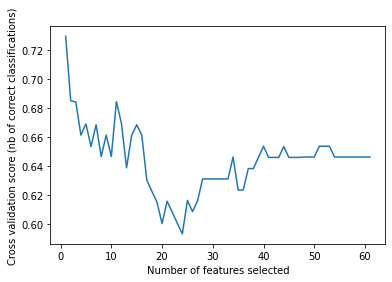

Playing computer games 2
51 How logical of a person do you think you are?
58 Do you like to sit in front of a computer for long hours?


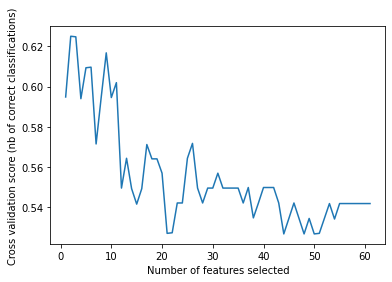

Playing board games 12
9 I prefer to spend my money on...._The latest technology
12 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar
14 Choose a pet which you prefer to keep._Cat
15 Choose a pet which you prefer to keep._Dog
39 What is your favorite color?_Purple
41 What is your favorite color?_White
45 What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions
46 What is your learning style? (Pick one that benefit you the most)_By reading a physical book
54 Are you a perfectionist?
56 Do you have lot of patience?
57 Do you organize your schedule well?
60 Can you understand others' perspectives and feelings?


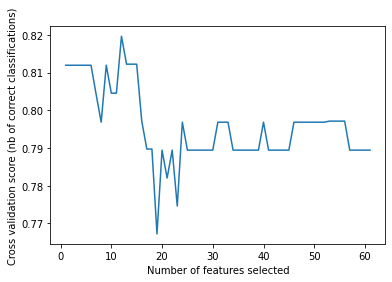

Reading 15
1 Gender: _Male
4 What boosts your confidence ? _When someone acknowledges you
5 What boosts your confidence ? _When you accomplish a project
6 I prefer to spend my money on...._Food
23 What is your favorite time of the day?_Evening
24 What is your favorite time of the day?_Morning
26 Would you rather visit the future or the past?_The future
28 What do you worry more about the most?_Money
33 When you retire, you'd like to live..._In a hectic big city
42 What is your favorite color?_Yellow
46 What is your learning style? (Pick one that benefit you the most)_By reading a physical book
47 What is your learning style? (Pick one that benefit you the most)_By reading an e-Book
49 Do you enjoy challenges?
50 How creative of a person do you think you are?
60 Can you understand others' perspectives and feelings?


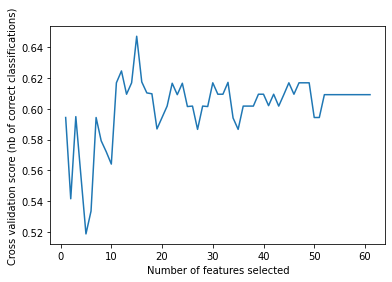

Team sports 4
1 Gender: _Male
9 I prefer to spend my money on...._The latest technology
15 Choose a pet which you prefer to keep._Dog
34 When you retire, you'd like to live..._In a small town


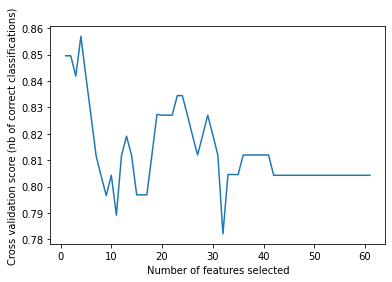

Exercising 27
1 Gender: _Male
2 What boosts your confidence ? _By leading others to success
3 What boosts your confidence ? _Get the most/ special attention among the members
5 What boosts your confidence ? _When you accomplish a project
6 I prefer to spend my money on...._Food
7 I prefer to spend my money on...._Home Improvements
10 How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph
12 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar
14 Choose a pet which you prefer to keep._Cat
15 Choose a pet which you prefer to keep._Dog
18 Choose a pet which you prefer to keep._Horse
23 What is your favorite time of the day?_Evening
25 What is your favorite time of the day?_Night
29 What do you worry more about the most?_The state of the world
30 What do you worry more about the most?_Your family and friends
31 What do you worry more about the most?_Your future
36 When you retire, you'd like to live..._Tra

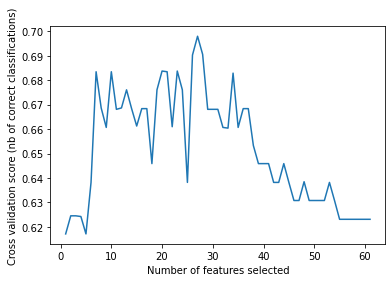

Writing 1
32 When you retire, you'd like to live..._Exactly where I live now


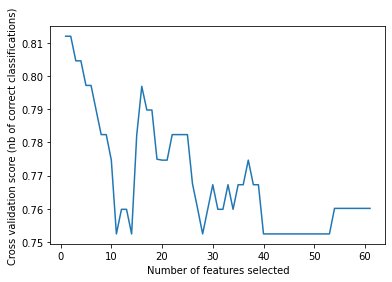

Dancing 52
1 Gender: _Male
2 What boosts your confidence ? _By leading others to success
3 What boosts your confidence ? _Get the most/ special attention among the members
4 What boosts your confidence ? _When someone acknowledges you
5 What boosts your confidence ? _When you accomplish a project
6 I prefer to spend my money on...._Food
7 I prefer to spend my money on...._Home Improvements
10 How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph
11 How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud
12 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar
13 How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper
14 Choose a pet which you prefer to keep._Cat
15 Choose a pet which you prefer to keep._Dog
18 Choose a pet which you prefer to keep._Horse
20 Choose a pet which you prefer to keep._Rabbit
23 What is yo

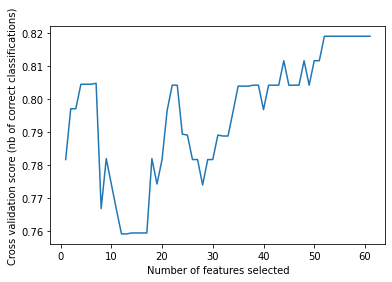

Gardening 1
56 Do you have lot of patience?


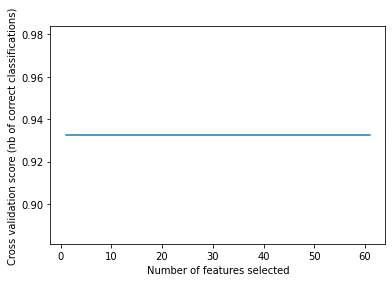

Painting 5
1 Gender: _Male
5 What boosts your confidence ? _When you accomplish a project
19 Choose a pet which you prefer to keep._I'm not a pet person
50 How creative of a person do you think you are?
51 How logical of a person do you think you are?


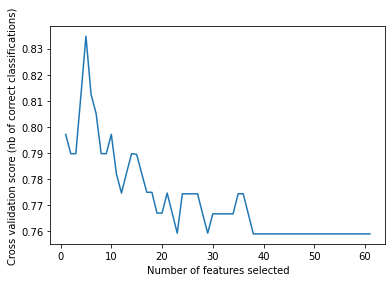

Cooking 2
7 I prefer to spend my money on...._Home Improvements
42 What is your favorite color?_Yellow


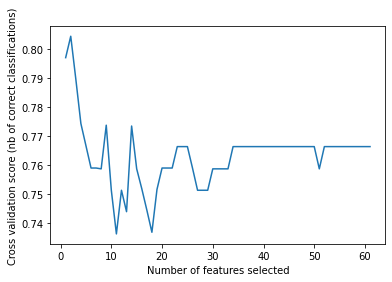

Singing 1
33 When you retire, you'd like to live..._In a hectic big city


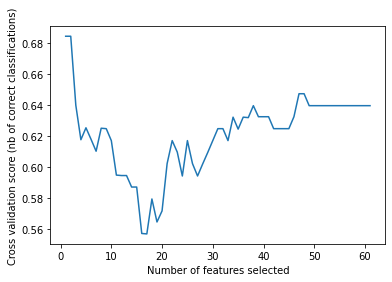

Puzzles 1
30 What do you worry more about the most?_Your family and friends


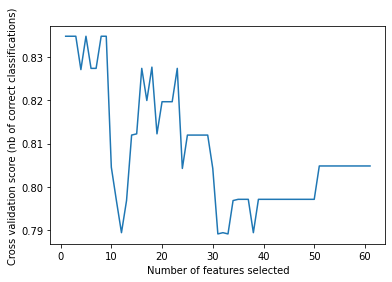

18 Choose a pet which you prefer to keep._Horse


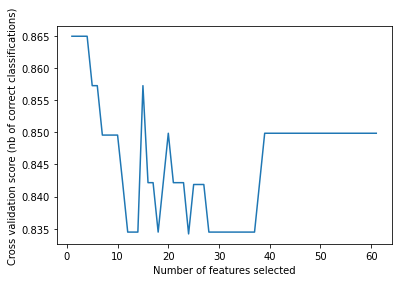

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Fishing 1
11 How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud


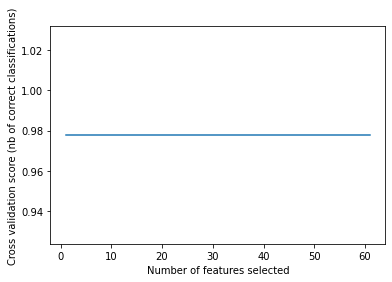

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Watching movies 1
7 I prefer to spend my money on...._Home Improvements


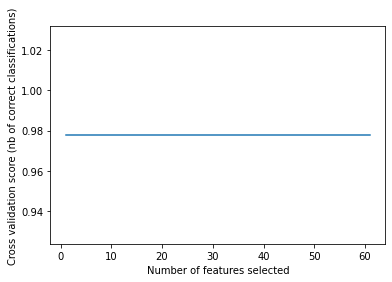

Watching TV series 1
40 What is your favorite color?_Red


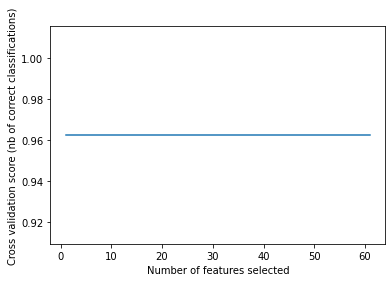

Sleeping 1
56 Do you have lot of patience?


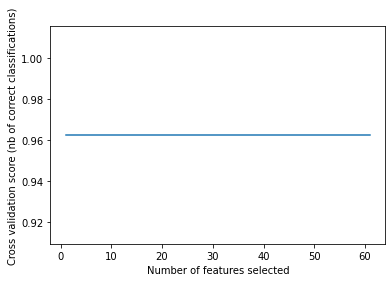

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Photography and Videography 1
18 Choose a pet which you prefer to keep._Horse


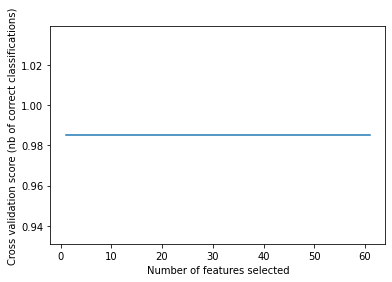

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Listening to music 1
27 Would you rather visit the future or the past?_The past


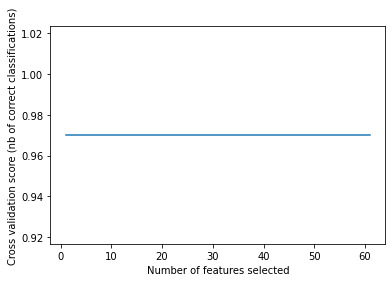

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


ValueError: ignored

In [47]:
scoring = 'f1_micro'
min_features_to_select=1
rfecv_by_class = []

for i in range(y_train.shape[1]):
  model = LogisticRegression()
  rfecv = RFECV(model, step=1, cv=5, min_features_to_select=min_features_to_select, scoring=scoring)
  rfecv.fit(x_train, y_train[:,i])
  rfecv_by_class.append(rfecv.ranking_)
  print(y.columns[i], rfecv.n_features_)
  for i in range(len(x.columns)): 
    if rfecv.support_[i]:
      print(i+1, x.columns[i])

# pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# selected_features = np.mean(selected_features, axis=0)
# print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (nb of correct classifications)")
  plt.plot(range(min_features_to_select,
                len(rfecv.grid_scores_) + min_features_to_select),
          rfecv.grid_scores_)
  plt.show()

rfecv_by_class = np.array(rfecv_by_class)  

##### Evaluation

In [48]:
rfe_analysis = sort_by_questions(np.mean(rfecv_by_class, axis=0), x, ascending=True) 
params = adapt_models[("Twin_SVM", MLTSVM)]
scoring = 'f1_micro'

results = {}
for i in range(len(rfe_analysis.index)):
  best_k_features = select_best_k_features(rfe_analysis, k=i+1)
  x = filter_features(best_k_features, df_norm)
  x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
  y_sparse = sparse.csr_matrix(y_train)
  x_sparse = sparse.csr_matrix(x_train)
  clf = GridSearchCV(MLTSVM(), params, cv=5, n_jobs=-1, scoring=scoring)
  clf.fit(x_sparse, y_sparse)
  y_pred = clf.predict(x_test)
  score = f1_score(y_test, y_pred, average="micro")
  print("Number of best k features:", len(best_k_features), "score:",score)

Number of best k features: 1 score: 0.40291262135922334
Number of best k features: 2 score: 0.34172661870503596
Number of best k features: 3 score: 0.30809399477806787
Number of best k features: 4 score: 0.31070496083550914
Number of best k features: 5 score: 0.3314917127071823
Number of best k features: 6 score: 0.3323529411764706
Number of best k features: 7 score: 0.3323262839879154
Number of best k features: 8 score: 0.3626373626373627
Number of best k features: 9 score: 0.36000000000000004
Number of best k features: 10 score: 0.3817567567567568
Number of best k features: 11 score: 0.3832116788321168
Number of best k features: 12 score: 0.3948339483394834
Number of best k features: 13 score: 0.3844660194174757
Number of best k features: 14 score: 0.36625514403292186
Number of best k features: 15 score: 0.3724696356275304
Number of best k features: 16 score: 0.39835728952772076
Number of best k features: 17 score: 0.4117647058823529
Number of best k features: 18 score: 0.40632054176

In [49]:
best_k_features = select_best_k_features(rfe_analysis, k=23)
best_k_features

['Gender: ',
 'How do you organize your thoughts? Please pick whichever is closest.',
 "Can you understand others' perspectives and feelings?",
 'Do you organize your schedule well?',
 'How creative of a person do you think you are?',
 'Do you have lot of patience?',
 'What is your learning style? (Pick one that benefit you the most)',
 "When you retire, you'd like to live...",
 'What do you worry more about the most?',
 'What is your favorite color?',
 'Do you enjoy challenges?',
 'What is your favorite time of the day?',
 'What boosts your confidence ? ',
 'Do you like to sit in front of a computer for long hours?',
 'Do you enjoy making others happy?',
 'I prefer to spend my money on....',
 'Would you rather visit the future or the past?',
 'Are you a trusting person?',
 'Are you a perfectionist?',
 'Are you a curious person?',
 'How logical of a person do you think you are?',
 'How confident are you in your own abilities?',
 'Do you enjoy socializing with large groups of people?']

In [55]:
# 23 features
display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Reading(19),Cooking(17),Exercising(14),Playing computer games(12),Singing(10),Playing board games(9),Puzzles(8),Painting(7),Badminton(7),Writing(6),Dancing(5),Team sports(3),Gardening(2),Sleeping(1),Collecting(1),Playing a musical instrument(1),Watching movies(1),Fishing(1),Photography and Videography(1),Watching TV series(0),Listening to music(0),Crocheting(0)
Twin_SVM,42.233010,68.085106,60.000000,60.000000,52.941176,44.444444,43.750000,38.461538,33.333333,18.750000,22.222222,29.629630,46.153846,0.000000,0.000000,13.333333,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0
Binary_Relevance_MLP,39.316239,66.666667,28.571429,51.851852,33.333333,28.571429,14.285714,46.153846,58.823529,30.769231,13.333333,22.222222,66.666667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
Classifier_Chain_Extra_Tree,36.231884,51.428571,38.461538,48.275862,33.333333,60.000000,35.294118,42.105263,42.105263,21.052632,0.000000,0.000000,66.666667,28.571429,0.000000,0.000000,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0
Classifier_Chain_Decision_Tree,35.658915,56.250000,42.857143,40.000000,37.037037,50.000000,0.000000,26.666667,44.444444,22.222222,16.666667,40.000000,66.666667,0.000000,0.000000,22.222222,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
Binary_Relevance_Extra_Tree,35.497835,61.538462,32.000000,25.000000,58.333333,35.294118,35.294118,26.666667,33.333333,28.571429,0.000000,16.666667,44.444444,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
Classifier_Chain_MLP,35.185185,63.414634,38.095238,26.086957,46.153846,20.000000,16.666667,0.000000,50.000000,30.769231,0.000000,20.000000,66.666667,0.000000,0.000000,0.000000,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0
Binary_Relevance_Decision_Tree,34.241245,62.857143,35.714286,32.000000,37.037037,40.000000,19.047619,28.571429,26.666667,20.000000,0.000000,44.444444,60.000000,0.000000,0.000000,0.000000,0.000000,0.0,66.666667,0.0,0.0,0.0,0.0
Binary_Relevance_kNN_A,32.835821,58.536585,35.714286,35.714286,35.714286,23.529412,40.000000,11.111111,12.500000,28.571429,18.181818,16.666667,44.444444,0.000000,0.000000,28.571429,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0
Multi-Label_KNN,32.835821,58.536585,35.714286,35.714286,35.714286,23.529412,40.000000,11.111111,12.500000,28.571429,18.181818,16.666667,44.444444,0.000000,0.000000,28.571429,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0
ARAM_Neural_Network,32.352941,65.000000,44.444444,34.482759,33.333333,11.111111,31.578947,22.222222,23.529412,20.000000,15.384615,0.000000,44.444444,28.571429,0.000000,0.000000,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0


# Save model
https://stackabuse.com/scikit-learn-save-and-restore-models/

In [ ]:
import pickle
# Save to file in the current working directory
pkl_filename = "Classifier_Chain_Extra_Tree_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)


In [ ]:
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)